<a href="https://www.bigdatauniversity.com"><img src = "https://ibm.box.com/shared/static/jvcqp2iy2jlx2b32rmzdt0tx8lvxgzkp.png" width = 300, align = "center"></a>

<h1 align=center><font size = 5> RESTRICTED BOLTZMANN MACHINES</font></h1>

### Introduction
__Restricted Boltzmann Machine (RBM):__  RBMs are shallow neural nets that learn to reconstruct data by themselves in an unsupervised fashion.  


## Table of Contents
<div class="alert alert-block alert-info" style="margin-top: 20px">
- <p><a href="#ref1">Initialization</a></p>
- <p><a href="#ref2">RBM Layers</a></p>
- <p><a href="#ref3">How an RBM works in Deep Learning</a></p>
- <p><a href="#ref4">RBM training</a></p>
<p></p>
</div>
----------------


#### How does it work?
Simply, RBM takes the inputs and translates them to a set of numbers that represents them. Then, these numbers can be translated back to reconstruct the inputs. Through several forward and backward passes, the RBM will be trained, and a trained RBM can reveal which features are the most important ones when detecting patterns.   

#### Why are RBMs important?
It can automatically extract __meaningful__ features from a given input.

#### What are the applications of RBM?
RBM is useful for <a href='http://www.cs.utoronto.ca/~hinton/absps/netflixICML.pdf'>  Collaborative Filtering</a>, dimensionality reduction, classification, regression, feature learning, topic modeling and even __Deep Belief Networks__.



#### Is RBM a generative model?
RBM is a generative model. What is a generative model?

First, lets see what is different betwee discriminative and generative model: 

__Discriminative:__Consider a classification problem in which we want to learn to distinguish between Sedan cars (y = 1) and SUV cars (y = 0), based on some features of an cars. Given a training set, an algorithm like logistic regression tries to find a straight line—that is, a decision boundary—that separates the suv and sedan. 
__Generative:__ looking at cars, we can build a model of what Sedan cars look like. Then, looking at SUVs, we can build a separate model of what SUV cars look like. Finally, to classify a new car, we
can match the new car against the Sedan model, and match it against the SUV model, to see whether the new car looks more like the SUV or Sedan. 

Generative Models specify a probability distribution over a dataset of input vectors. we can do both supervise and unsupervise tasks with generative models:
- In an unsupervised task, we try to form a model for P(x), where x is an input vector. 
- In the supervised task, we first form a model for P(x|y), where y is the label for x. For example, if y indicates whether an example is a SUV (0) or a Sedan (1), then p(x|y = 0) models the distribution of SUVs’ features, and p(x|y = 1) models the distribution of Sedans’ features. If we manage to find P(x|y) and P(y), then we can use `bayes rule` to estimate P(y|x), because: p(y|x) = p(x|y)p(y)/p(x)

Can we build a generative model, and then use it to create synthetic data by directly sampling from the modelled probability distributions? Lets see. 

<a id="ref1"></a>
### Initialization

First we have to load the utility file which  contains different utility functions that are not connected
in any way to the networks presented in the tutorials, but rather help in
processing the outputs into a more understandable way.

In [1]:
import urllib
response = urllib.urlopen('http://deeplearning.net/tutorial/code/utils.py')
content = response.read()
target = open('utils.py', 'w')
target.write(content)
target.close()

Now, we load in all the packages that we use to create the net including the TensorFlow package:

In [2]:
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
#!pip install pillow
from PIL import Image
#import Image
from utils import tile_raster_images
import matplotlib.pyplot as plt
%matplotlib inline

We will be using the MINST dataset to practice the usage of RBMs. The following cell loads the MINST dataset.

In [3]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
trX, trY, teX, teY = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


----------------

<a id="ref2"></a>
### RBM layers

An RBM has two layers. The first layer of the RBM is called the __visible__ (or input layer). MNIST images have 784 pixels, so the visible layer must have 784 input nodes. 
The second layer is the __hidden__ layer, which possesses i neurons in our case. Each hidden unit has a binary state, which we’ll call it __si__, and turns either on or off (i.e., si = 1 or si = 0) with a probability that is a logistic function of the inputs it receives from the other j visible units, called for example, p(si = 1). For our case, we'll use 500 nodes in the hidden layer, so i = 500.

<img src="https://ibm.box.com/shared/static/vcu5e0luynq3o66pmt3lr9ywni5jakcj.png" alt="RBM Model" style="width: 400px;"/>

     

Each node in the first layer also has a __bias__. We will denote the bias as “vb” for the visible units. The _vb_ is shared among all visible units.

Here we define the  __bias__ of second layer as well. We will denote the bias as “hb” for the hidden units. The _hb_ is shared among all visible units

In [4]:
vb = tf.placeholder("float", [784])
hb = tf.placeholder("float", [500])

We have to define weights among the input layer and hidden layer nodes. In the weight matrix, the rows are equal to the input nodes, and the columns are equal to the output nodes. Let __W__ be the Tensor of 784x500 (784 - number of visible neurons, 500 - number of hidden neurons) that represents weights between neurons. 

In [5]:
W = tf.placeholder("float", [784, 500])

----------------

<a id="ref3"></a>
### What RBM can do after training?
Think RBM as a model that have been trained, and now it can calculate the probability of observing a case (e.g. wet road) given some hidden/latent values (e.g. raining). That is, the RBM can be viewed as a generative model that assigns a probability to each possible `binary state vectors` over its visible units (v). 

What are the possible __binary states vectors__? 
- The visible layer can have different binary states, or so called, configurations. For example, in the 7 unit visible layer (above photo), it has ${2^{7}}$ differnt configurations, and each configuration has its probablity (assuming we dont have any bias).
    - (0,0,0,0,0,0,0) --> p(config1)=p(v1)=p(s1=0,s2=0, .., s7=0)
    - (0,0,0,0,0,0,1) --> p(config2)=p(v2)=p(s1=0,s2=1, .., s7=1)
    - (0,0,0,0,0,1,0) --> p(config3)=p(v3)=p(s1=1,s2=0, .., s7=0)
    - (0,0,0,0,0,1,1) --> p(config4)=p(v4)=p(s1=1,s2=1, .., s7=1)
    - etc.


So, for example if we have 784 units in the visible layer, it will generates a probability distribution over all the ${2^{784}}$ possible visible vectors, i.e, p(v). 

Now, it would be really cool, if a model (after training) can calculate the probablity of visible layer, given hidden layer values.

### How to train an RBM? 

RBM has two phases: 1) Forward Pass, and  2) Backward Pass or Reconstruction:


__Phase 1) Forward pass:__  Processing happens in each node in the hidden layer. That is, input data from all visible nodes are being passed to all hidden nodes. This computation begins by making stochastic decisions about whether to transmit that input or not (i.e. to determine the state of each hidden layer). At the hidden layer's nodes, __X__ is multiplied by a __W__ and added to __h_bias__. The result of those two operations is fed into the sigmoid function, which produces the node’s output/state. As a result, one output is produced for each hidden node. So, for each row in the training set, __a tensor of probabilities__ is generated, which in our case it is of size [1x500], and totally 55000 vectors (_h0_=[55000x500]).


Then, we take the tensor of probabilities (as from a sigmoidal activation) and make samples from all the distributions, __h0__.  That is, we sample the activation vector from the probability distribution of hidden layer values. Samples are used to estimate the negative phase gradient which will be explained later.

In [6]:
X = tf.placeholder("float", [None, 784])
_h0= tf.nn.sigmoid(tf.matmul(X, W) + hb)  #probabilities of the hidden units
h0 = tf.nn.relu(tf.sign(_h0 - tf.random_uniform(tf.shape(_h0)))) #sample_h_given_X

Before we go further, let's look at an example of sampling:

In [11]:
with  tf.Session() as sess:
    a= tf.constant([0.7, 0.1, 0.8, 0.2])
    print sess.run(a)
    
    c = sess.run(tf.nn.sigmoid(a))
    print c
    b=sess.run(tf.random_uniform(tf.shape(a)))
    print b
    print sess.run(a-b)
    print sess.run(tf.sign( a - b))
    print sess.run(tf.nn.relu(tf.sign( a - b)))

[ 0.69999999  0.1         0.80000001  0.2       ]
[ 0.66818774  0.52497917  0.68997449  0.54983395]
[ 0.00187325  0.62516212  0.51856756  0.7773869 ]
[ 0.69812673 -0.5251621   0.28143245 -0.57738692]
[ 1. -1.  1. -1.]
[ 1.  0.  1.  0.]


__Phase 2) Backward Pass (Reconstruction):__
The RBM reconstructs data by making several forward and backward passes between the visible and hidden layers.

So, in the second phase (i.e. reconstruction phase), the samples from the hidden layer (i.e. h0) play the role of input. That is, __h0__ becomes the input in the backward pass. The same weight matrix and visible layer biases are used to go through the sigmoid function. The produced output is a reconstruction which is an approximation of the original input.

In [12]:
_v1 = tf.nn.sigmoid(tf.matmul(h0, tf.transpose(W)) + vb) 
v1 = tf.nn.relu(tf.sign(_v1 - tf.random_uniform(tf.shape(_v1)))) #sample_v_given_h
h1 = tf.nn.sigmoid(tf.matmul(v1, W) + hb)

Reconstruction steps: 
- Get one data point from data set, like _x_, and pass it through the net
- Pass 0: (x)  -> (x:-:_h0) -> (h0:-:v1)   (v1 is reconstruction of the first pass)
- Pass 1: (v1) -> (v1:-:h1) -> (_h0:-:v2)   (v2 is reconstruction of the second pass)
- Pass 2: (v2) -> (v2:-:h2) -> (_h1:-:v3)   (v3 is reconstruction of the third pass)
- Pass n: (vn) -> (vn:-:hn+1) -> (_hn:-:vn+1)(vn is reconstruction of the nth pass)

----------------

<a id="ref4"></a>
### How to calculate gradients?
In order to train an RBM, we have to maximize the product of probabilities assigned to the training set V (a matrix, where each row of it is treated as a visible vector v):
<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/d42e9f5aad5e1a62b11b119c9315236383c1864a" >


Or equivalently, maximize the expected log probability of V:
<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/ba0ceed99dca5ff1d21e5ace23f5f2223f19efc0" >

Equivalently, we can define the objective function as __the average negative log-likelihood__ and try to minimize it. To achieve this, we need the partial derivative of this function in respect to all of its parameters. And it can be shown that the above equation is indirectly the weights and biases function, so minimization of the objective function here means modifying/optimizing the weight vector W. So, we can use __stochastic gradient descent__ to find the optimal weight and consequently minimize the objective function. When we derive, it give us 2 terms, called positive and negative gradient. These negative and positive phases reflect their effect on the probability density defined by the model. The positive one depends on observations (X), and the second one depends on only the model. 
 
The __Positive phase__ increases the probability of training data.  
The __Negative phase__ decreases the probability of samples generated by the model.  

The negative phase is hard to compute, so we use a method called __Contrastive Divergence (CD)__ to approximate it.  It is designed in such a way that at least the direction of the gradient estimate is somewhat accurate, even when the size is not (In real world models, more accurate techniques like CD-k or PCD are used to train RBMs). During the calculation of CD, we have to use __Gibbs sampling__ to sample from our model distribution.    

Contrastive Divergence is actually matrix of values that is computed and used to adjust values of the W matrix. Changing W incrementally leads to training of W values. Then on each step (epoch), W is updated to a new value W' through the equation below:
$W' = W + alpha * CD$ 

__ What is Alpha?__  
Here, alpha is some small step rate and is also known as the "learning rate".

__How can we calculate CD?__  
We can perform single-step Contrastive Divergence (CD-1) taking the following steps:

1. Take a training sample from X, compute the probabilities of the hidden units and sample a hidden activation vector h0 from this probability distribution.
 - $\_h0 = sigmoid(X \otimes W + hb)$
 - $h0 = sampleProb(h0)$
2. Compute the [outer product](https://en.wikipedia.org/wiki/Outer_product) of X and h0 and call this the positive gradient.
 - $w\_pos\_grad = X \otimes h0$  (Reconstruction in the first pass)  
3. From h, reconstruct v1, and then take a sample of the visible units, then resample the hidden activations h1 from this. (**Gibbs sampling step**)
 - $\_v1 = sigmoid(h0 \otimes transpose(W) + vb)$
 - $v1 = sample_prob(v1)$  (Sample v given h)
 - $h1 = sigmoid(v1 \otimes W + hb)$
4. Compute the outer product of v1 and h1 and call this the negative gradient.
 - $w\_neg\_grad = v1 \otimes h1$  (Reconstruction 1)
5. Now, CD equals the positive gradient minus the - negative gradient, CD is a matrix of size 784x500. 
 - $CD = (w\_pos\_grad - w\_neg\_grad) / datapoints$
6. Update the weight to be CD times some learning rate
 - $W' = W + alpha*CD$
7. At the end of the algorithm, the visible nodes will store the value of the sample.

#### What is sampling here (sampleProb)?
In forward pass: We randomly set the values of each hi to be 1 with probability $sigmoid(v \otimes W + hb)$.  
In reconstruction: We randomly set the values of each vi to be 1 with probability $ sigmoid(h \otimes transpose(W) + vb)$.

In [13]:
alpha = 1.0
w_pos_grad = tf.matmul(tf.transpose(X), h0)
w_neg_grad = tf.matmul(tf.transpose(v1), h1)
CD = (w_pos_grad - w_neg_grad) / tf.to_float(tf.shape(X)[0])
update_w = W + alpha * CD
update_vb = vb + alpha * tf.reduce_mean(X - v1, 0)
update_hb = hb + alpha * tf.reduce_mean(h0 - h1, 0)

### What is objective function?

__Goal: Maximize the likelihood of our data being drawn from that distribution__

__Calculate error:__  
In each epoch, we compute the "error" as a sum of the squared difference between step 1 and step n,
e.g the error shows the difference between the data and its reconstruction.

__Note:__ tf.reduce_mean computes the mean of elements across dimensions of a tensor.

In [14]:
err = tf.reduce_mean(tf.square(X - v1))

Let's start a session and initialize the variables:

In [15]:
cur_w = np.zeros([784, 500], np.float32)
cur_vb = np.zeros([784], np.float32)
cur_hb = np.zeros([500], np.float32)
prv_w = np.zeros([784, 500], np.float32)
prv_vb = np.zeros([784], np.float32)
prv_hb = np.zeros([500], np.float32)
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

Let look at the error of the first run:

In [16]:
sess.run(err, feed_dict={X: trX, W: prv_w, vb: prv_vb, hb: prv_hb})

0.48123461

To recall, the whole algorithm works as:  
- For each epoch, and for each batch do:
  - Compute CD as: 
     - For each data point in batch do:
        - w_pos_grad = 0, w_neg_grad= 0 (matrices)
        - Pass data point through net, calculating v (reconstruction) and h
        - update w_pos_grad = w_pos_grad + X$\otimes$h0
        - update w_neg_grad = w_neg_grad + v1$\otimes$h1
     - CD = average of pos_grad and neg_grad by dividing them by the amount of data points.
  - Update weights and biases W' = W + alpha * CD 
  - Calculate error
- Repeat for the next epoch until error is small or after some fixed number of epochs.

Epoch: 0 reconstruction error: 0.063096
Epoch: 1 reconstruction error: 0.054548
Epoch: 2 reconstruction error: 0.050436
Epoch: 3 reconstruction error: 0.048514
Epoch: 4 reconstruction error: 0.046891


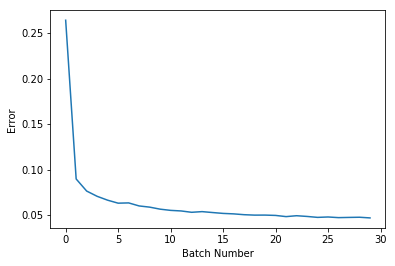

In [17]:
#Parameters
epochs = 5
batchsize = 100
weights = []
errors = []

for epoch in range(epochs):
    for start, end in zip( range(0, len(trX), batchsize), range(batchsize, len(trX), batchsize)):
        batch = trX[start:end]
        cur_w = sess.run(update_w, feed_dict={ X: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_vb = sess.run(update_vb, feed_dict={  X: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_hb = sess.run(update_hb, feed_dict={ X: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        prv_w = cur_w
        prv_vb = cur_vb
        prv_hb = cur_hb
        if start % 10000 == 0:
            errors.append(sess.run(err, feed_dict={X: trX, W: cur_w, vb: cur_vb, hb: cur_hb}))
            weights.append(cur_w)
    print 'Epoch: %d' % epoch,'reconstruction error: %f' % errors[-1]
plt.plot(errors)
plt.xlabel("Batch Number")
plt.ylabel("Error")
plt.show()

What is the last weight after training?

In [ ]:
uw = weights[-1].T
print uw # a weight matrix of shape (500,784)

We can take each hidden unit and visualize the connections between that hidden unit and each element in the input vector. 

Let's plot the current weights:
__tile_raster_images__ helps in generating a easy to grasp image from a set of samples or weights. It transform the __uw__ (with one flattened image per row of size 784), into an array (of size $25*20$) in which images are reshaped and layed out like tiles on a floor.

In [ ]:
tile_raster_images(X=cur_w.T, img_shape=(28, 28), tile_shape=(25, 20), tile_spacing=(1, 1))
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline
image = Image.fromarray(tile_raster_images(X=cur_w.T, img_shape=(28, 28) ,tile_shape=(25, 20), tile_spacing=(1, 1)))
### Plot image
plt.rcParams['figure.figsize'] = (18.0, 18.0)
imgplot = plt.imshow(image)
imgplot.set_cmap('gray')  

Each tile in the above visualization corresponds to a vector of connections between a hidden unit and visible layer's units. 

Let's look at one of the learned weights corresponding to one of hidden units for example. In this particular square, the gray color represents weight = 0, and the whiter it is, the more positive the weights are (closer to 1). Conversely, the darker pixels are, the more negative the weights. The positive pixels will increase the probability of activation in hidden units (after muliplying by input/visible pixels), and negative pixels will decrease the probability of a unit hidden to be 1 (activated). So, why is this important?  So we can see that this specific square (hidden unit) can detect a feature (e.g. a "/" shape) and if it exists in the input.

In [ ]:
from PIL import Image
image = Image.fromarray(tile_raster_images(X=cur_w.T[10:11], img_shape=(28, 28),tile_shape=(1, 1), tile_spacing=(1, 1)))
### Plot image
plt.rcParams['figure.figsize'] = (4.0, 4.0)
imgplot = plt.imshow(image)
imgplot.set_cmap('gray')  

Let's look at the reconstruction of an image.

First we plot one of images:

In [ ]:
sample_case = trX[1:2]
img = Image.fromarray(tile_raster_images(X=sample_case, img_shape=(28, 28),tile_shape=(1, 1), tile_spacing=(1, 1)))
plt.rcParams['figure.figsize'] = (2.0, 2.0)
imgplot = plt.imshow(img)
imgplot.set_cmap('gray')  #you can experiment different colormaps (Greys,winter,autumn)

Now let's pass this image through the net:

In [ ]:
hh0 = tf.nn.sigmoid(tf.matmul(X, W) + hb)
vv1 = tf.nn.sigmoid(tf.matmul(hh0, tf.transpose(W)) + vb)
feed = sess.run(hh0, feed_dict={ X: sample_case, W: prv_w, hb: prv_hb})
rec = sess.run(vv1, feed_dict={ hh0: feed, W: prv_w, vb: prv_vb})

Here we plot the reconstructed image:

In [ ]:
img = Image.fromarray(tile_raster_images(X=rec, img_shape=(28, 28),tile_shape=(1, 1), tile_spacing=(1, 1)))
plt.rcParams['figure.figsize'] = (2.0, 2.0)
imgplot = plt.imshow(img)
imgplot.set_cmap('gray') 

## Want to learn more?

Running deep learning programs usually needs a high performance platform. PowerAI speeds up deep learning and AI. Built on IBM's Power Systems, PowerAI is a scalable software platform that accelerates deep learning and AI with blazing performance for individual users or enterprises. The PowerAI platform supports popular machine learning libraries and dependencies including Tensorflow, Caffe, Torch, and Theano. You can download a [free version of PowerAI](https://cocl.us/ML0120EN_PAI).

Also, you can use Data Science Experience to run these notebooks faster with bigger datasets. Data Science Experience is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, DSX enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of DSX users today with a free account at [Data Science Experience](https://cocl.us/ML0120EN_DSX)This is the end of this lesson. Hopefully, now you have a deeper and intuitive understanding regarding the LSTM model. Thank you for reading this notebook, and good luck on your studies.

Created by: 
<a href = "https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, Gabriel Garcez Barros Souza

### References:
https://en.wikipedia.org/wiki/Restricted_Boltzmann_machine  
http://deeplearning.net/tutorial/rbm.html  
http://deeplearning4j.org/restrictedboltzmannmachine.html  
http://imonad.com/rbm/restricted-boltzmann-machine/  
